# Download/Install


In [ ]:
# download main dataset and csv files
!wget https://cups.mail.ru/api_v2/task/1089/89
!wget https://cups.mail.ru/api_v2/task/1089/90
!wget https://cups.mail.ru/api_v2/task/1089/83
!wget https://cups.mail.ru/api_v2/task/1089/84
!wget https://cups.mail.ru/api_v2/task/1089/85
!wget https://cups.mail.ru/api_v2/task/1089/106
!wget https://cups.mail.ru/api_v2/task/1089/107
!mv 83 sample_submission.csv
!mv 84 test.csv
!mv 85 train.csv
!mv 106 test_extended.csv
!mv 107 sample_submission_extended.csv
!unzip 89
!unzip 90
!unzip avia-test-extended.zip
!rm avia-test-extended.zip
!rm 89
!rm 90
!rm -r __MACOSX

In [ ]:
!mv -v avia-test/* avia-test-extended/

In [39]:
cd avia-test-extended

/content/avia-test-extended


In [40]:
!for f in *.jpeg; do mv -- "$f" "${f%.jpeg}.png"; done

In [41]:
cd ..

/content


In [ ]:
# download additional dataset
!wget https://zenodo.org/record/3464319/files/airplane-dataset-asoc.zip?download=1
!unzip airplane-dataset-asoc.zip?download=1
!rm -r airplane-dataset-asoc.zip?download=1

In [3]:
cd 'airplane-dataset-trans'

/content/airplane-dataset-trans


In [4]:
!rm TYPE-NAMES.txt
!rm names.txt
!rm '#num.txt'
!rm '#num.xlsx' 

In [5]:
cd ..

/content


In [3]:
# kaggle.json
from google.colab import files
 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"crashnester","key":"e8f1f979c1799d93dd1898a7730ae479"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

In [ ]:
# dowload pre-trained efficientnet
!kaggle datasets download -d hmendonca/efficientnet-pytorch
!unzip efficientnet-pytorch.zip
!rm -r efficientnet-pytorch.zip

# Libraries

In [10]:
import os
import sys
sys.path = ['EfficientNet-PyTorch/EfficientNet-PyTorch-master',] + sys.path
import pandas as pd
import tensorflow as tf
import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm
import torch
import torchvision.models as models
import torch.nn as nn
from efficientnet_pytorch import model as enet
import random
from sklearn.model_selection import KFold, StratifiedKFold
import albumentations as A

# Quick EDA

In [35]:
df = pd.read_csv('train.csv')
df['img_path'] = df['filename'].apply(lambda x: 'avia-train/' + x + '.png')
df = df.drop(['filename'], axis=1)
df.head(10)

,sign,img_path
0,0,avia-train/200d8766-4240-44d1-a2da-65dc4ee7973...
1,0,avia-train/87174854-b7b6-4cb2-8183-4ca2bbd26b9...
2,0,avia-train/c089638e-b683-436a-a3a3-3e5be972c4f...
3,1,avia-train/8790e76c-f485-49a6-abaf-3147436ca08...
4,0,avia-train/c06b01db-8934-4c72-b568-508a32c4b17...
5,1,avia-train/56a03a71-b4c6-406c-b987-b4c55c0dff8...
6,0,avia-train/b68d8d48-3753-49f9-9801-340d9bcbf7f...
7,0,avia-train/e0eb3d64-2a4e-4a39-a175-91425a21279...
8,0,avia-train/381b6344-c4ff-48e5-aca7-5458015c42f...
9,0,avia-train/4d1c69cc-731d-474f-840d-8a3f0286edb...


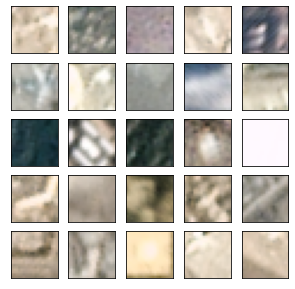

In [29]:
plt.figure(figsize=(5, 5))
for i in range(25):
    image = imageio.imread(df.loc[i, 'img_path'])
    image = image[:,:,:3]
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
plt.show()

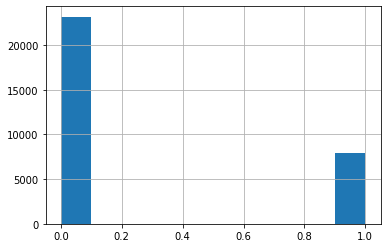

In [26]:
df['sign'].hist()

In [10]:
def set_seed(seed = 0):
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state
 
seed = 42
random_state = set_seed(seed)

In [21]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


# Augmentation

In [12]:
img_sz = 224

ttransform = A.Compose([
    A.Resize(img_sz, img_sz, cv2.INTER_NEAREST),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=180, p=0.5),
    A.RandomBrightness(p=0.5),
])

vtransform = A.Compose([
    A.Resize(img_sz, img_sz, cv2.INTER_NEAREST),
])

In [13]:
class ClassificationDataset:
    def __init__(self, image_paths, targets, tr=None, train=True): 
        self.image_paths = image_paths
        self.targets = targets
        self.train = train
        self.tr = tr
         
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):      
        image = imageio.imread(self.image_paths[item])
        image = image[:,:,:3]
        targets = self.targets[item]
     
        image = self.tr(image = image)["image"].transpose((2, 1, 0)).astype(np.float32)
        image = image / 255.0
                
        return {
            "image": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

In [14]:
# read additional dataset
paths_list = []

os.chdir('.')
for root, dirs, files in os.walk('airplane-dataset-trans/', topdown = False):
   for name in files:
        paths_list.append(os.path.join(root, name))

additional_paths = pd.DataFrame({'sign': 1, 'img_path': paths_list})
for i in range(len(additional_paths)):
    if 'backgroud-2' in additional_paths.img_path.iloc[i] or \
        'baground' in additional_paths.img_path.iloc[i] or \
        'baground-1' in additional_paths.img_path.iloc[i] :
        additional_paths.sign.iloc[i] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [15]:
df = df.append(additional_paths)
df = df.sample(frac=1).reset_index(drop=True)

In [16]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(pretrained_model[backbone]))

        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
        self.conv1 = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=3, bias=False)
 
    def extract(self, x):
        return self.enet(x)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.extract(x)
        x = self.myfc(x)
        
        return x

In [17]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
 
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
 
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam
 
 
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [18]:
def train(data_loader, model, optimizer, device):
    model.train()
    
    for data in tqdm(data_loader, position=0, leave=True, desc='Training'):
        inputs = data['image']
        targets = data['targets']
        
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets.view(-1, 1), use_cuda=True)
        inputs = inputs.to(device, dtype=torch.float)
        targets_a = targets_a.to(device, dtype=torch.float)
        targets_b = targets_b.to(device, dtype=torch.float)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()
        
def evaluate(data_loader, model, device):
    model.eval()
    
    final_targets = []
    final_outputs = []
    
    with torch.no_grad():
        for data in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            inputs = data['image']
            targets = data['targets']
            
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            
            output = model(inputs)
            output = torch.sigmoid(output)
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(output)
            
            del output, targets, inputs
            
    return final_outputs, final_targets

In [19]:
paths = [
 'efficientnet-b0-08094119.pth',
 'efficientnet-b1-dbc7070a.pth',
 'efficientnet-b2-27687264.pth',
 'efficientnet-b3-c8376fa2.pth',
 'efficientnet-b4-e116e8b3.pth',
 'efficientnet-b5-586e6cc6.pth',
 'efficientnet-b6-c76e70fd.pth',
 'efficientnet-b7-dcc49843.pth',
]

# Train

In [ ]:
baseline_name = 'efficientnet-b4'
pretrained_model = {
    'efficientnet-b4': paths[4]
}
 
epochs = 25
batch_size = 32
X = df.img_path.values
Y = df.sign.values
skf = StratifiedKFold(n_splits=5)
fold = 0
criterion = nn.BCEWithLogitsLoss()
for train_index, test_index in skf.split(X, Y):
    model = enetv2(baseline_name, out_dim=1)
    model.to(device)
 
    train_images, valid_images = X[train_index], X[test_index]
    train_targets, valid_targets = Y[train_index], Y[test_index]
 
    train_dataset = ClassificationDataset(image_paths=train_images, targets=train_targets, tr=ttransform)
    valid_dataset = ClassificationDataset(image_paths=valid_images, targets=valid_targets, tr=vtransform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
 
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
 
    best_score = 0
    for epoch in range(epochs):
        print(f'\nepoch {epoch + 1}')
        train(train_loader, model, optimizer, device=device)
        predictions, valid_targets = evaluate(valid_loader, model, device=device)
        roc_auc = metrics.roc_auc_score(valid_targets, predictions)
 
        if roc_auc > best_score:
            torch.save(model.state_dict(), f'models/{baseline_name}-{str(fold)}.pt')
            best_score = roc_auc
        print(f'Valid ROC AUC={roc_auc} (best {best_score})')
 
    print(f'best score: {best_score}\n\n')
    fold += 1

# Evaluate

In [42]:
test_data = pd.read_csv('test.csv')
test_data['img_path'] = test_data['filename'].apply(lambda x: 'avia-test-extended/' + x + '.png')
test_data = test_data.drop(['filename'], axis=1)
test_data.head()

,img_path
0,avia-test-extended/68f33844-472b-4111-b600-f90...
1,avia-test-extended/7d93a21d-1f16-49ce-8fcc-edf...
2,avia-test-extended/4a820650-7acd-489a-ad14-9d7...
3,avia-test-extended/819b216b-2b6c-4539-a722-706...
4,avia-test-extended/45f7c47d-03cc-40cd-acc5-b8c...


In [ ]:
device = 'cuda'
baseline_name = 'efficientnet-b4'

models = []
for i in range(fold):
    model = enetv2(baseline_name, out_dim=1)
    model.to(device)
    model.load_state_dict(torch.load(f'models/{baseline_name}-{i}.pt'))

    models.append(model)

In [45]:
sample_submission = pd.read_csv('sample_submission_extended.csv')

In [ ]:
preds = []
for each in models:
    test_dataset = ClassificationDataset(image_paths=test_data.img_path.values, targets=sample_submission.sign.values, tr=vtransform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    predictions, valid_targets = evaluate(test_loader, each, device=device)
    preds.append(predictions)

outputs = np.mean(preds, axis = 0)

# Submission

In [ ]:
sample_submission['sign'] = outputs
sample_submission.to_csv('submission_b4_224.csv', index=False)
sample_submission.head()